In [1]:
# Some configurations to "beautify" plots
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams["font.family"] = "Libre Franklin"
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["savefig.facecolor"] = "white"

# "What went wrong?" data processing edition
So, we got through our data acquisition.
The raw images look good.
What do we do with that? 

It's recommended to follow a standardised processing protocol, like `fMRIPrep`, but many times
there are hidden parameters which are not applicable for rodents.
Here are some of the most common obstacles that were unearthed during the development of
`fMRIPrep-rodents`.

## Example 1
First, we will correct for non-uniformity that is inherent across the intensity values of many types of "weighted" images.
This example used the default call to `N4BiasFieldCorrection` from `ANTs`.
Let's look at the original first:

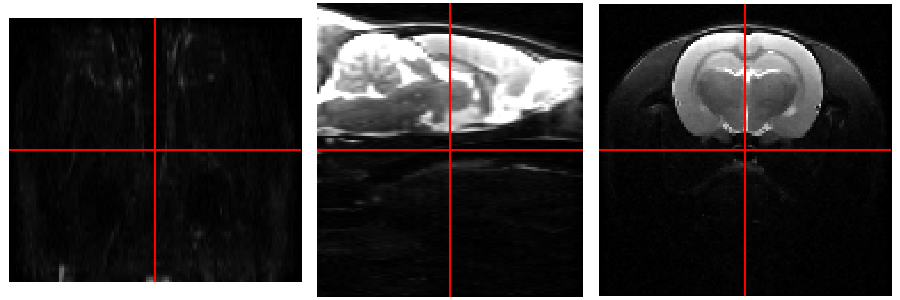

In [2]:
import nanslice.jupyter as ns
%matplotlib widget

ns.three_plane('assets/example-1_desc-orig_proc.nii.gz', interactive=True, cmap='gray')

Now let's look at the corrected image. The results are not as good as they could be.

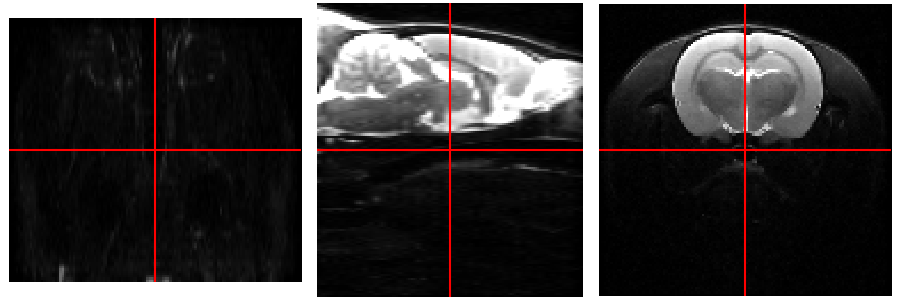

In [3]:
ns.three_plane('assets/example-1_desc-n4default_proc.nii.gz', interactive=True, cmap='gray')

```{admonition} What do you think the problem was?
:class: dropdown
Anisotropic voxel sizes with isotropic mm parameters

**To correct this**, define the number of elements in the bspline grid (including fewer elements in the slice direction), 
rather than using a bspline fitting distance which is given in mm.
Also consider reducing the shrink factor, which helps speed up processing.
As this is applied the same in every plane, out-of-plane anisotropic voxels can be blurry.
```

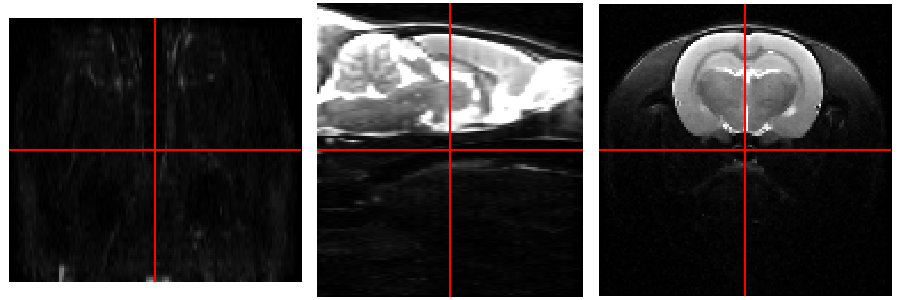

In [4]:
ns.three_plane('assets/example-1_desc-n4final_proc.nii.gz', interactive=True)

## Example 2
Our next step is "brain masking".
We will use the popular FSL tool `bet` to remove non-brain tissue (aka skull-strip) an image.
This step helps downstream preprocessing such as registration.

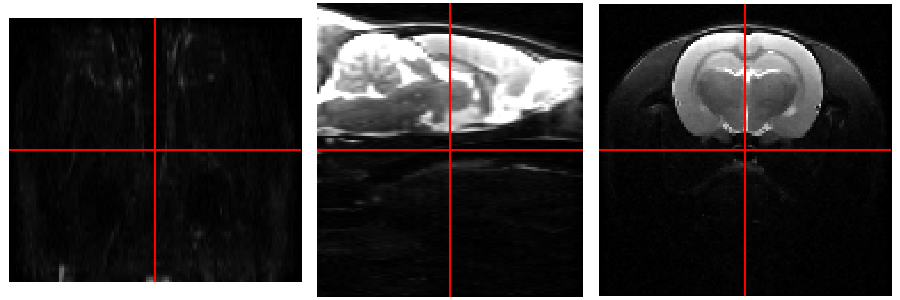

In [5]:
ns.three_plane('assets/example-2_desc-orig_proc.nii.gz', interactive=True, cmap='gray')

After applying the mask supplied by `bet`, the image looks like this:

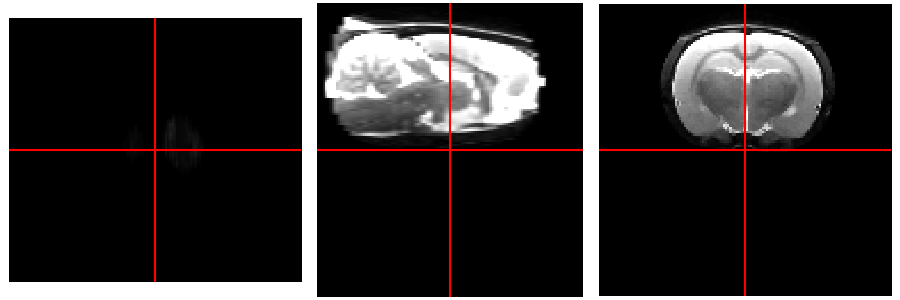

In [6]:
ns.three_plane('assets/example-2_desc-bet_proc.nii.gz', interactive=True, cmap='gray')

```{admonition} What do you think the problem was?
:class: dropdown
`bet` assumes that the input data has a brain that is shaped like a humans (i.e., mostly spherical), but our data is more cylindrical.
```

Let's try another tool, instead this one is made for rats: `AFNI`'s `3dSkullStrip` with the `-rat` flag.

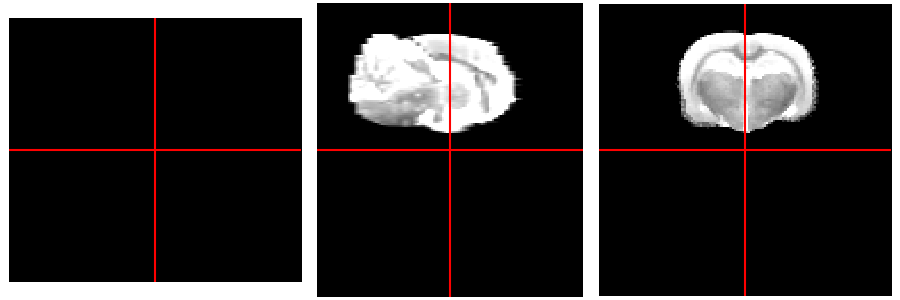

In [7]:
ns.three_plane('assets/example-2_desc-3dss_proc.nii.gz', interactive=True, cmap='gray')

```{admonition} What do you think the problem was?
:class: dropdown
Although the shape assumption is correct, `3dSkullStrip` assumes that the input image is T2-weighted. However, our image is T1-weighted.

**To correct this**, try using an atlas-based brain extraction method.
Although this method takes longer than some of the other methods, it is robust to image contrast and across scanners.
It is for this reason that the NiPreps tools, such as `NiRodents` and `NiBabies`, have developed their own versions 
of the `ANTs` atlas-based extraction tool: `antsBrainExtraction`.
```

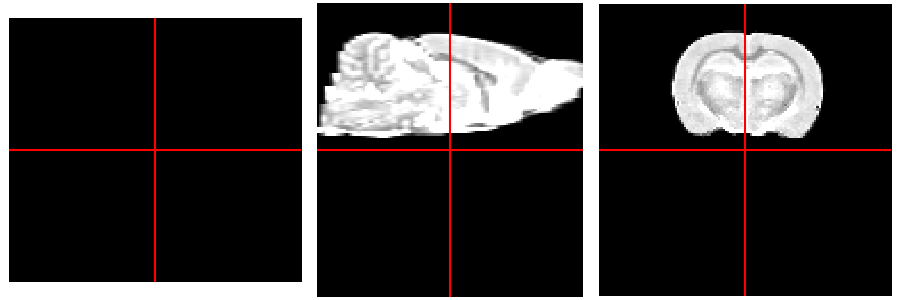

In [8]:
ns.three_plane('assets/example-2_desc-arts_proc.nii.gz', interactive=True, cmap='gray')

## Example 3
This example involves normalisation of a subject's anatomical image to a standard space template.
First, let's load the target image (this image isn't completely raw; it has been clipped and normalised):

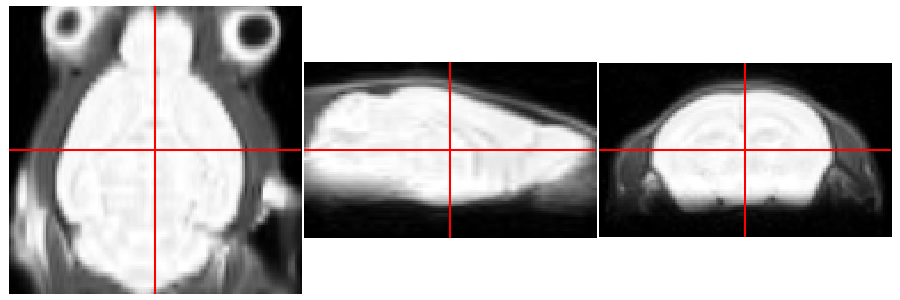

In [9]:
ns.three_plane('assets/example-3_desc-orig_proc.nii.gz', interactive=True, cmap='gray')

and the template:

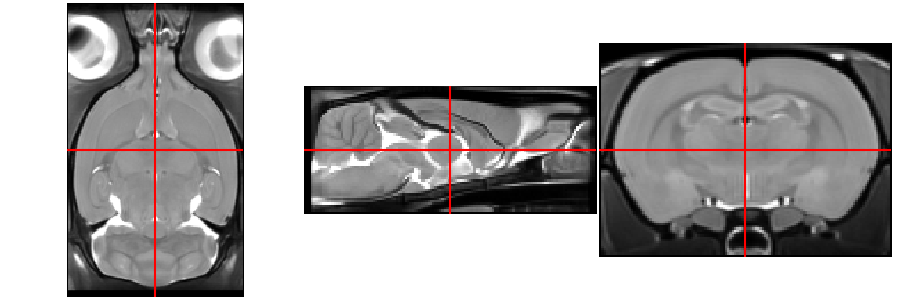

In [10]:
ns.three_plane('assets/example-3_desc-tpl_proc.nii.gz', interactive=True, cmap='gray')

Now, let's look at the processed image:

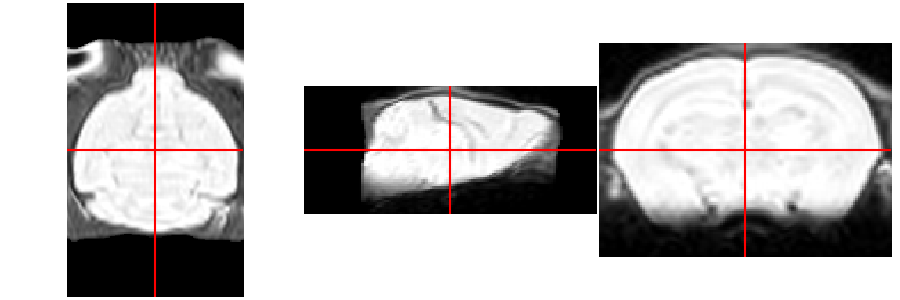

In [11]:
ns.three_plane('assets/example-3_desc-warped_proc.nii.gz', interactive=True, cmap='gray')

```{admonition} What do you think the problem was?
:class: dropdown
Wrong prior information: we tried to register a mouse target image to rat template!

The reference image was a rat, but the target image was a mouse.
Although these species may have similar brain anatomy, the difference in scale was too large for the registration algorithm to overcome.

**To correct this**, make sure that the template and target image are as similar as possible.
```

## Example 4
This example uses `FSL`'s `topup` tool to correct for susceptibility distortion in EPI images.
We have two spin-echo images, one with the phase-encoding direction that is superior to inferior, 
and the other with a phase-encoding direction going from inferior to superior.

Below are the mean images of the volumes acquired for each phase-encoding direction:

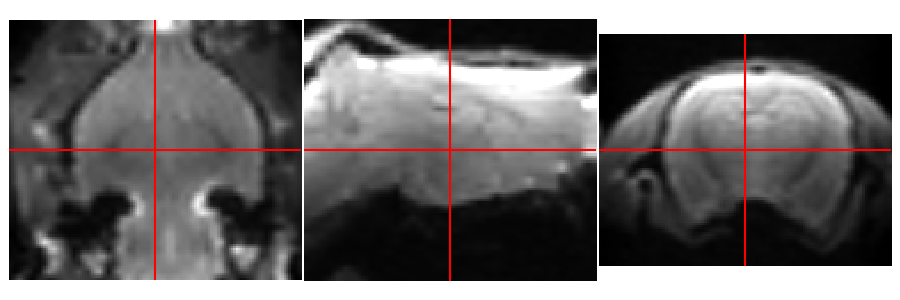

In [12]:
ns.three_plane('assets/example-4_dir-IS_desc-tmean_proc.nii.gz', interactive=True, cmap='gray')

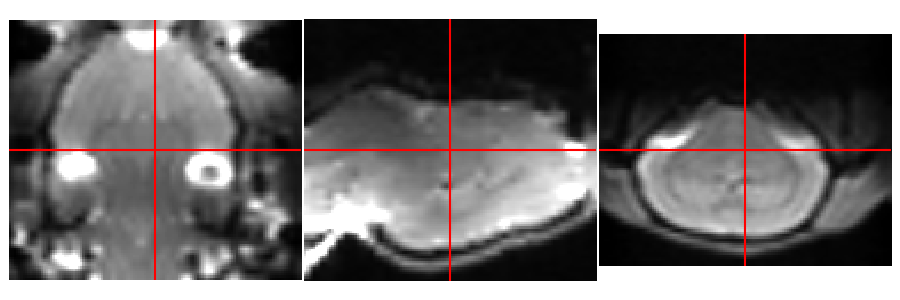

In [13]:
ns.three_plane('assets/example-4_dir-SI_desc-tmean_proc.nii.gz', interactive=True, cmap='gray')

The `topup` output is less than desirable:

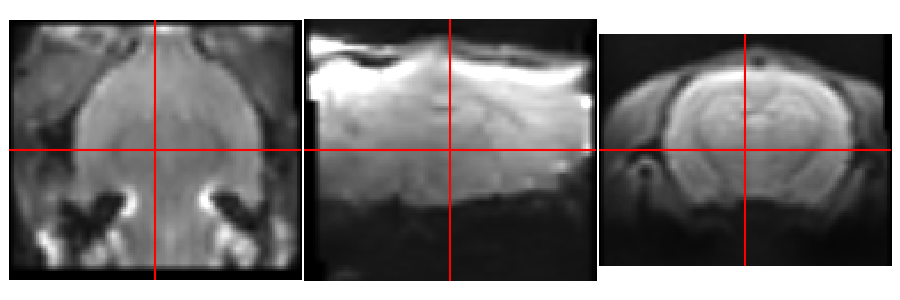

In [14]:
ns.three_plane('assets/example-4_desc-orig_proc.nii.gz', interactive=True, cmap='gray')

What do you think the problem was?
```{hint}
:class: dropdown
Check the image header with the code below.
```

In [15]:
import nibabel as nb

img = nb.load('assets/example-4_dir-IS_desc-tmean_proc.nii.gz')
hdr = img.header
print(hdr)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [ 3 60 48 36  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.  0.4 0.4 0.6 1.5 1.  1.  1. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'6.0.5:9e026117'
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.70710677
quatern_d       : 0.70710677
qoffset_x       : 12.0
qoffset_y       : -9.731
qoffset_z       : -11.266
srow_x       

```{admonition} What was the problem?
:class: dropdown
Many `topup` parameters are defined in mm, which is too large for rodent voxel sizes.

**There's no perfect solution to correct for this (yet!)**.
This is an example why image headers are manipulated to represent "human-sized" voxels. This approach is *not recommended*.

It may be possible to change the units of the header to microns and the voxel sizes accordingly.
Although this still involves manipulation of the header, and the voxel sizes will be much larger than those of humans, 
it would probably have the same effect as scaling the header but while keeping the header information credible.

This approach still requires further testing.
```

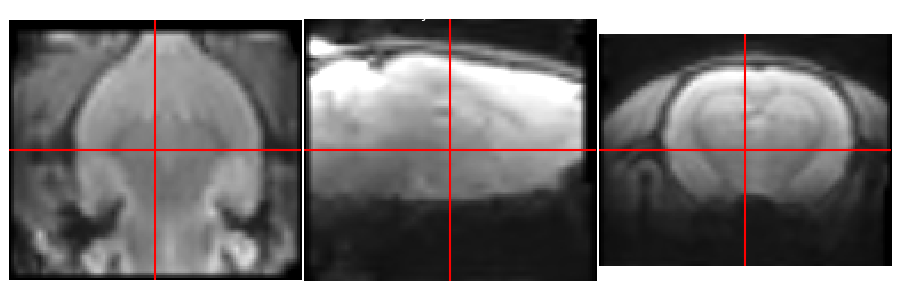

In [16]:
ns.three_plane('assets/example-4_desc-micron_proc.nii.gz', interactive=True, cmap='gray', title='unit adjusted header')

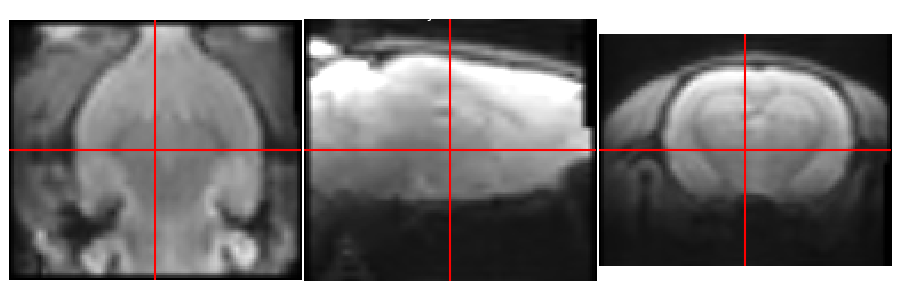

In [17]:
ns.three_plane('assets/example-4_desc-scaled_proc.nii.gz', interactive=True, cmap='gray', title='scale adjusted header')

## Example 5
Our final example uses EPI data normalised in `SPM`.
The warp calculated the mean across time to a template image, and then applied it to each frame individually.

Below is the output warped EPI volume:

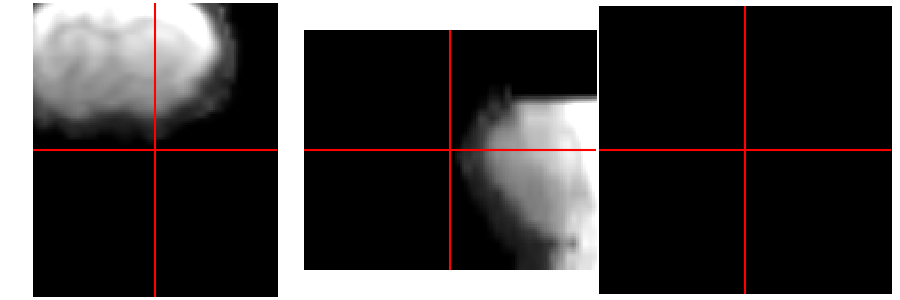

In [18]:
ns.three_plane('assets/example-5_proc.nii.gz', interactive=True, cmap='gray')

```{admonition} What was the problem?
:class: dropdown
`SPM` normalisation has a `bounding box` parameter, which was not changed from the default.
The image origin is not in the middle of the image, so when the warp is calculated with the default Bounding Box parameters, the top of the image is outside
the bounding box and consequently is cut off.

**To correct this**, either set bounding boxes to `NaN` or use other software which may not require specific bounding boxes.
```